In [1]:
import sys
sys.path.append('cocoapi\PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.CenterCrop(224),                             
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


In [27]:
data_loader.vocab_size

AttributeError: 'DataLoader' object has no attribute 'vocab_size'

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
#     print(features)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)
    return features

def clean_sentence(output):
    sentence = ""
    for idx in output:
        if idx == 0:
            continue
        if idx == 1:
            break
        word = data_loader.dataset.vocab.idx2word[idx]
        sentence = sentence + word + ' '
        
    return sentence

def fetch_image(file_name):
    orig_image = Image.open(file_name).convert('RGB')
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    transform_test = transforms.Compose([ 
        transforms.Resize(256),                          
        transforms.CenterCrop(224),                             
        transforms.ToTensor(),                           
        transforms.Normalize((0.485, 0.456, 0.406),      
                             (0.229, 0.224, 0.225))])
    input_image = transform_test(orig_image)
    return orig_image, input_image

def generate_caption(input_image,encoder):
    print(input_image.shape)
    features = encoder(input_image).unsqueeze(1)
    features.to(device)
#     print(features.shape)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


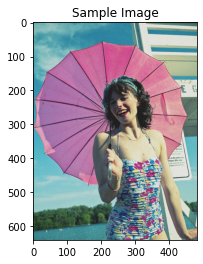

In [4]:
import os
file_name = 'girl_umbrella.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)

In [5]:
%load_ext autoreload
# %autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-1.pkl'
decoder_file = 'decoder-1.pkl'

embed_size = 512
hidden_size = 512

vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

encoder.load_state_dict(torch.load(os.path.join(os.getcwd(),'models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),'models', decoder_file)))

encoder.to(device)
decoder.to(device)

9 2048


DecoderRNN(
  (word_embeddings): Embedding(10321, 512)
  (embed): Embedding(10321, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=10321, bias=True)
)

In [7]:
v_features = encoder(input_image.reshape(1,3,224,224).to('cuda')).unsqueeze(1)

In [8]:
import pandas as pd

predicted_sentence,predicted_scores,predicted_indices = decoder.sample(v_features.to(device))

word_list = []
for t in range(0,20):
    for w in range(0,5):
        word = data_loader.dataset.vocab.idx2word[predicted_indices[t][0][w].item()]
        if word not in word_list:
            word_list.append(word)

word_indx_list = []
for word in word_list:
    word_indx_list.append(data_loader.dataset.vocab.word2idx[word])


myDataFrame = pd.DataFrame(columns = word_list)

for t in range(0,20):
    print(f'time = {t}')
    print(predicted_indices[t][0])
    print(predicted_scores[t][0])
    for w_indx in word_indx_list:
        if w_indx in predicted_indices[t][0]:
            index = (predicted_indices[t][0]==w_indx).nonzero().item()
            print(index)
            score = predicted_scores[t][0][index].item()
        else:
            score = 0
        key_word = data_loader.dataset.vocab.idx2word[w_indx]

        myDataFrame.loc[t,key_word] = score

myDataFrame.transpose().to_csv("Layer_Scores_"+file_name+".csv")
print(clean_sentence(predicted_sentence))

time = 0
tensor([   0, 5745, 8964, 2241, 4712], device='cuda:0')
tensor([27.4284,  4.6388,  4.5417,  4.3809,  4.3437], device='cuda:0',
       grad_fn=<SelectBackward0>)
0
1
2
3
4
time = 1
tensor([  3,  57, 243,  61,   9], device='cuda:0')
tensor([10.5126,  8.5804,  7.5859,  7.3090,  6.9399], device='cuda:0',
       grad_fn=<SelectBackward0>)
0
1
2
3
4
time = 2
tensor([194, 113, 145, 350, 152], device='cuda:0')
tensor([10.5569,  9.6164,  8.5932,  8.4923,  8.2323], device='cuda:0',
       grad_fn=<SelectBackward0>)
0
1
2
3
4
time = 3
tensor([146,  35,  39,   6, 331], device='cuda:0')
tensor([9.5646, 9.0121, 8.6638, 8.5922, 8.4963], device='cuda:0',
       grad_fn=<SelectBackward0>)
0
1
2
3
4
time = 4
tensor([  3,  61, 415, 232, 290], device='cuda:0')
tensor([10.3981, 10.2994,  8.8094,  7.9257,  7.1882], device='cuda:0',
       grad_fn=<SelectBackward0>)
0
1
2
3
4
time = 5
tensor([290, 291, 641, 229,  69], device='cuda:0')
tensor([7.6707, 7.5516, 7.2683, 7.1204, 7.0315], device='cuda:0',